In [ ]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

# Fetch historical stock data
def fetch_stock_data(ticker, start, end):
    data = yf.download(ticker, start=start, end=end)
    return data

# Data prep for closing price prediction
def preprocess_data(data, feature_column='Close', lookback=10):
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_data = scaler.fit_transform(data[feature_column].values.reshape(-1, 1))

    X, y = [], []
    for i in range(lookback, len(scaled_data)):
        X.append(scaled_data[i-lookback:i, 0])
        y.append(scaled_data[i, 0])

    X, y = np.array(X), np.array(y)
    X = np.reshape(X, (X.shape[0], X.shape[1], 1))
    return X, y, scaler

# Data prep for percent change prediction
def preprocess_data_change(data, feature_column='Close', label_column='FutureChange', lookback=10):
    data[label_column] = (data[feature_column].shift(-1) - data[feature_column]) / data[feature_column]

    X, y = [], []
    for i in range(lookback, len(data) - 1):
        X.append(data[label_column].iloc[i - lookback:i].values)  # Past lookback price changes
        y.append(data[label_column].iloc[i])  # Next price change

    X, y = np.array(X), np.array(y)
    X = np.reshape(X, (X.shape[0], X.shape[1], 1))  # Reshape for LSTM

    return X, y

# Data prep for log return prediction
def preprocess_data_log_return(data, feature_column='Close', label_column='LogReturn', lookback=10):
    data[label_column] = np.log(data[feature_column] / data[feature_column].shift(1))

    X, y = [], []
    for i in range(lookback, len(data)):
        X.append(data[label_column].iloc[i - lookback:i].values)
        y.append(data[label_column].iloc[i])

    X, y = np.array(X), np.array(y)
    X = np.reshape(X, (X.shape[0], X.shape[1], 1))
    y = y.reshape(-1, 1)

    return X, y

# Build the LSTM model
def build_lstm_model(input_shape):
    model = Sequential([
        LSTM(units=50, return_sequences=True, input_shape=input_shape, activation = "tanh"),
        Dropout(0.2),
        LSTM(units=50, return_sequences=False, activation = "tanh"),
        Dropout(0.2),
        Dense(units=25, activation='tanh'),
        Dense(units=1)
    ])

    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

# Recursively predict on own prediction to forecast trends
def recursive_prediction(model, input_data, actual_data, timesteps, scaler):
    predictions = []
    current_input = input_data[0]

    for _ in range(timesteps):
        predicted = model.predict(current_input.reshape(1, -1, 1))

        predicted_value = scaler.inverse_transform(predicted)[0][0]
        predictions.append(predicted_value)

        current_input = np.append(current_input[1:], predicted).reshape(-1, 1)

    actual = scaler.inverse_transform(actual_data.reshape(-1, 1))
    return predictions, actual

# Plot predictions vs actual values
def plot_predictions(actual, predicted, x_title, y_title, title):
    plt.figure(figsize=(12, 6))
    plt.plot(actual, label='Actual')
    plt.plot(predicted, label='Predicted')
    plt.xlabel(x_title)
    plt.ylabel(y_title)
    plt.title(title)
    plt.legend()
    plt.show()

# Plot training progress of model
def plot_history(history):
    plt.figure(figsize=(10, 4))
    plt.plot(history.history['loss'], label='Train Loss')

    if 'val_loss' in history.history:
        plt.plot(history.history['val_loss'], label='Val Loss')

    plt.title('Model Loss')
    plt.xlabel('Epochs')
    plt.xticks(np.arange(0, len(history.history['loss']) + 1, 1))
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

# Data preperation
def prepare_data(ticker, start_date, end_date, preprocess_func, lookback=10):
    data = fetch_stock_data(ticker, start=start_date, end=end_date)

    # Prepare data
    X, y, scaler = preprocess_func(data, lookback = lookback)

    train_split = int(0.8 * len(X))
    val_split = int(0.9 * len(X))
    X_train, y_train = X[:train_split], y[:train_split]
    X_val, y_val = X[train_split:val_split], y[train_split:val_split]
    X_test, y_test = X[val_split:], y[val_split:]
    return X_train, y_train, X_val, y_val, X_test, y_test, scaler

def make_predictions(model, X_test, y_test, scaler=None, start=0, finish=None):
  predictions = model.predict(X_test)
  if scaler:
    predictions = scaler.inverse_transform(predictions)
    actual = scaler.inverse_transform(y_test.reshape(-1, 1))
  else:
      actual = y_test

  predictions = predictions[start:finish]
  actual = actual[start:finish]

  return predictions, actual


[*********************100%***********************]  1 of 1 completed


Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


157/157 ━━━━━━━━━━━━━━━━━━━━ 9s 25ms/step - loss: 0.0541 - val_loss: 0.0052
Epoch 2/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - loss: 0.0037 - val_loss: 0.0022
Epoch 3/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 0.0034 - val_loss: 0.0021
Epoch 4/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 0.0030 - val_loss: 0.0020
Epoch 5/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 6s 40ms/step - loss: 0.0028 - val_loss: 0.0020
Epoch 6/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 0.0026 - val_loss: 0.0020
Epoch 7/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 0.0027 - val_loss: 0.0020
Epoch 8/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - loss: 0.0024 - val_loss: 0.0020
Epoch 9/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 0.0024 - val_loss: 0.0021
Epoch 10/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - loss: 0.0024 - val_loss: 0.0020


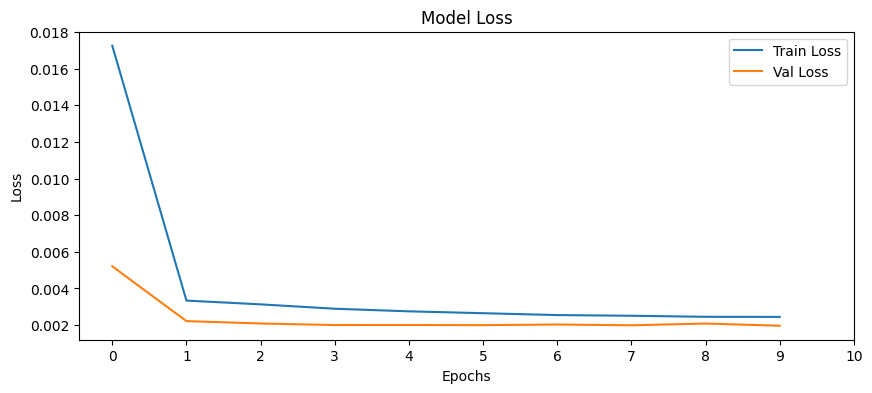

20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step


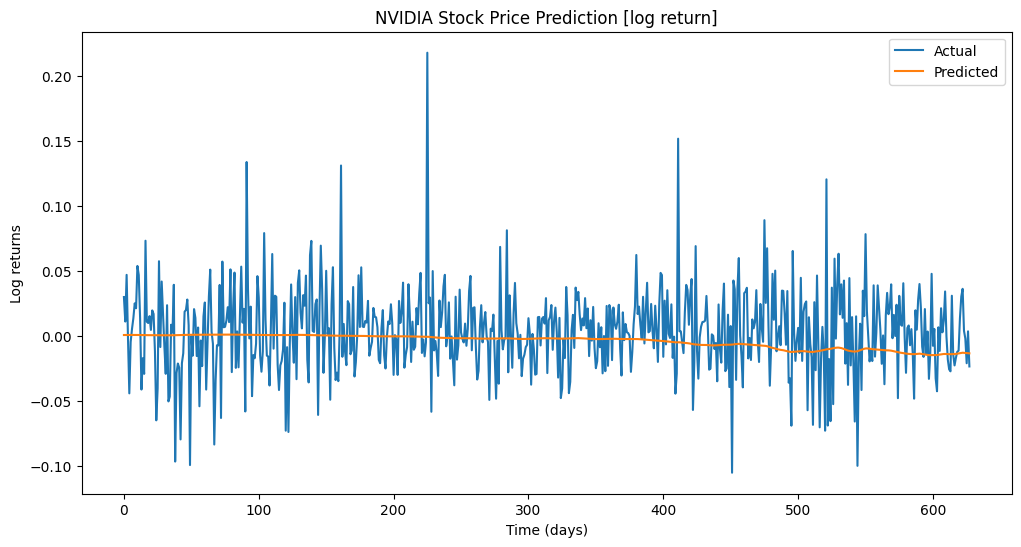

In [ ]:
# Log returns
X_train, y_train, X_val, y_val, X_test, y_test, scaler = prepare_data("NVDA", "2000-01-01", "2025-01-01", preprocess_data_log_return)
model_log = build_lstm_model(input_shape=(X_train.shape[1], 1))
model_log.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_val, y_val))
plot_history(model_log.history)
predictions, actual = make_predictions(model_log, X_test, y_test, scaler)
plot_predictions(actual, predictions, "Time (days)", "Log returns", "NVIDIA Stock Price Prediction [log return]")

In [ ]:
X_train, y_train, X_val, y_val, X_test, y_test, scaler = prepare_data("NVDA", "2000-01-01", "2025-01-01", preprocess_data, lookback=10)
model = build_lstm_model(input_shape=(X_train.shape[1], 1))
model.summary()

[*********************100%***********************]  1 of 1 completed
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_19"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_38 (LSTM)                       │ (None, 10, 50)              │          10,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_38 (Dropout)                 │ (None, 10, 50)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_39 (LSTM)                       │ (None, 50)                  │          20,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_39 (Dropout)                 │ (None, 50)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_38 (Dense)                     │ (None, 25)                  │           1,275 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_39 (Dense)                     │ (None, 1)                   │              26 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 31,901 (124.61 KB)

 Trainable params: 31,901 (124.61 KB)

 Non-trainable params: 0 (0.00 B)

[*********************100%***********************]  1 of 1 completed

Epoch 1/10



/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


157/157 ━━━━━━━━━━━━━━━━━━━━ 9s 22ms/step - loss: 4.7685e-05 - val_loss: 9.2342e-05
Epoch 2/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - loss: 2.4562e-06 - val_loss: 7.5984e-05
Epoch 3/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 2.3098e-06 - val_loss: 1.2930e-04
Epoch 4/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 2.9261e-06 - val_loss: 8.1868e-05
Epoch 5/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 2.0528e-06 - val_loss: 9.4172e-05
Epoch 6/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - loss: 2.4570e-06 - val_loss: 6.6119e-05
Epoch 7/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step - loss: 2.2288e-06 - val_loss: 1.1081e-04
Epoch 8/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 2.3182e-06 - val_loss: 1.3959e-04
Epoch 9/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - loss: 2.0671e-06 - val_loss: 8.1205e-05
Epoch 10/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step - loss: 2.2907e-06 - val_loss: 5.3039e-05


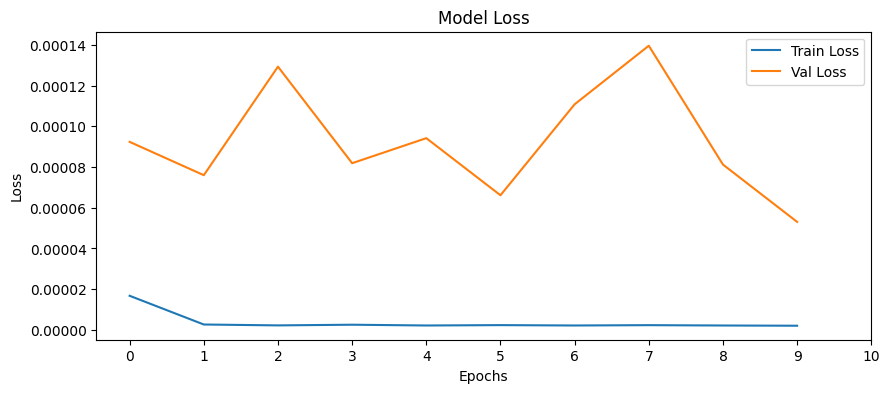

20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step


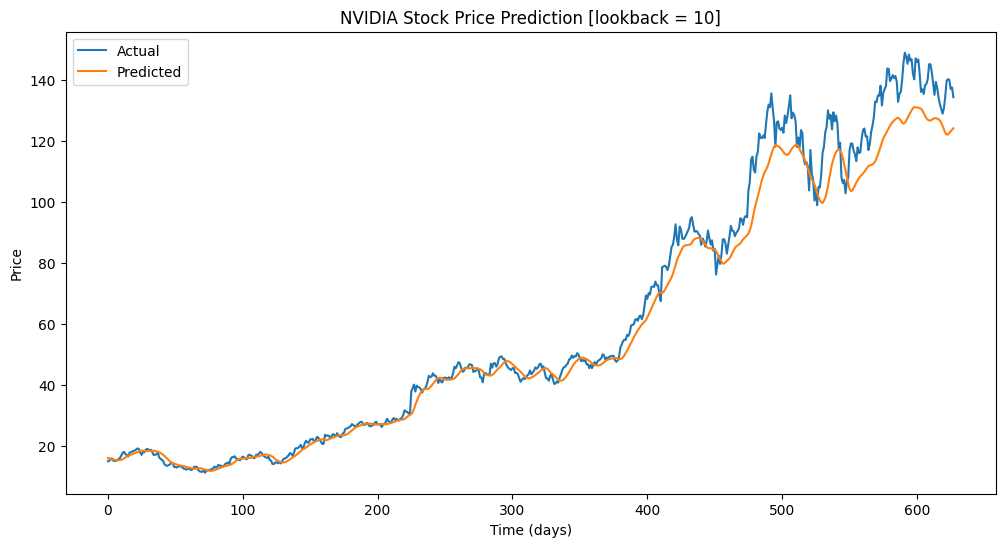

In [ ]:
# Price lookback = 10
X_train, y_train, X_val, y_val, X_test, y_test, scaler = prepare_data("NVDA", "2000-01-01", "2025-01-01", preprocess_data, lookback=10)
model = build_lstm_model(input_shape=(X_train.shape[1], 1))
model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_val, y_val))
plot_history(model.history)
predictions, actual = make_predictions(model, X_test, y_test, scaler)
plot_predictions(actual, predictions, "Time (days)", "Price", "NVIDIA Stock Price Prediction [lookback = 10]")

[*********************100%***********************]  1 of 1 completed

Epoch 1/10



/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


157/157 ━━━━━━━━━━━━━━━━━━━━ 13s 47ms/step - loss: 5.0694e-05 - val_loss: 1.6967e-04
Epoch 2/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step - loss: 2.1945e-06 - val_loss: 8.8214e-05
Epoch 3/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 8s 48ms/step - loss: 2.6928e-06 - val_loss: 1.2566e-04
Epoch 4/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 6s 38ms/step - loss: 2.4236e-06 - val_loss: 8.7464e-05
Epoch 5/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 10s 36ms/step - loss: 2.3677e-06 - val_loss: 8.0370e-05
Epoch 6/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 11s 43ms/step - loss: 1.7428e-06 - val_loss: 6.7742e-05
Epoch 7/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 10s 40ms/step - loss: 2.2143e-06 - val_loss: 7.1383e-05
Epoch 8/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step - loss: 1.9298e-06 - val_loss: 7.5164e-05
Epoch 9/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 6s 41ms/step - loss: 1.9661e-06 - val_loss: 8.2154e-05
Epoch 10/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 9s 32ms/step - loss: 2.0629e-06 - val_loss: 6.0524e-05


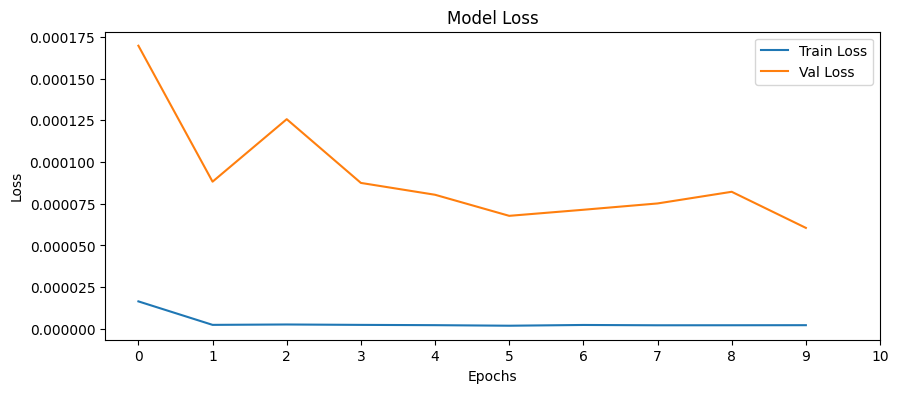

20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 57ms/step


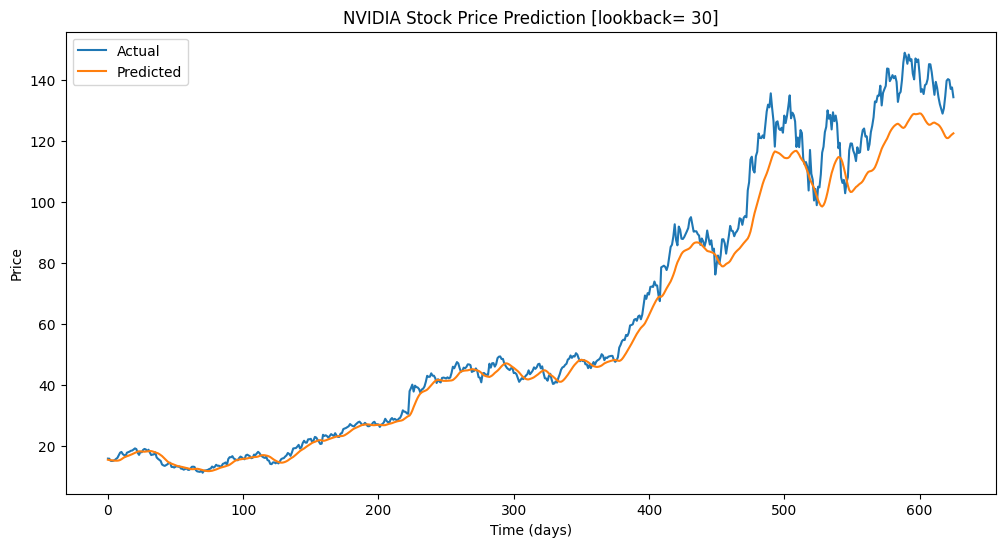

In [ ]:
# Price lookback =  30
X_train, y_train, X_val, y_val, X_test, y_test, scaler = prepare_data("NVDA", "2000-01-01", "2025-01-01", preprocess_data, lookback=30)
model_30 = build_lstm_model(input_shape=(X_train.shape[1], 1))
model_30.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_val, y_val))
plot_history(model_30.history)
predictions, actual = make_predictions(model_30, X_test, y_test, scaler)
plot_predictions(actual, predictions, "Time (days)", "Price", "NVIDIA Stock Price Prediction [lookback= 30]")

[*********************100%***********************]  1 of 1 completed
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
155/155 ━━━━━━━━━━━━━━━━━━━━ 21s 101ms/step - loss: 5.6457e-05 - val_loss: 8.3635e-05
Epoch 2/10
155/155 ━━━━━━━━━━━━━━━━━━━━ 21s 108ms/step - loss: 2.7072e-06 - val_loss: 9.8940e-05
Epoch 3/10
155/155 ━━━━━━━━━━━━━━━━━━━━ 19s 100ms/step - loss: 2.3534e-06 - val_loss: 7.2461e-05
Epoch 4/10
155/155 ━━━━━━━━━━━━━━━━━━━━ 20s 99ms/step - loss: 2.2428e-06 - val_loss: 1.5591e-04
Epoch 5/10
155/155 ━━━━━━━━━━━━━━━━━━━━ 21s 101ms/step - loss: 2.2216e-06 - val_loss: 7.2449e-05
Epoch 6/10
155/155 ━━━━━━━━━━━━━━━━━━━━ 21s 104ms/step - loss: 2.2986e-06 - val_loss: 6.7559e-05
Epoch 7/10
155/155 ━━━━━━━━━━━━━━━━━━━━ 20s 100ms/step - loss: 2.6707e-06 - val_loss: 9.6194e-05
Epoch 8/10
155/155 ━━━━━━━━━━━━━━━━━━━━ 20s 99ms/step - loss: 2.5255e-06 - val_loss: 5.9264e-05
Epoch 9/10
155/155 ━━━━━━━━━━━━━━━━━━━━ 21s 102ms/step - loss: 2.2831e-06 - val_loss: 6.7708e-05
Epoch 10/10
155/155 ━━━━━━━━━━━━━━━━━━━━ 16s 100ms/step - loss: 2.2303e-06 - val_loss: 5.6956e-05


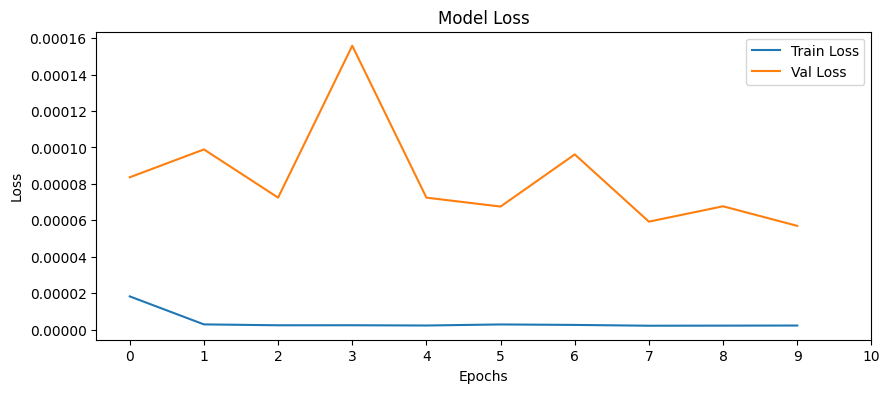

20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 67ms/step


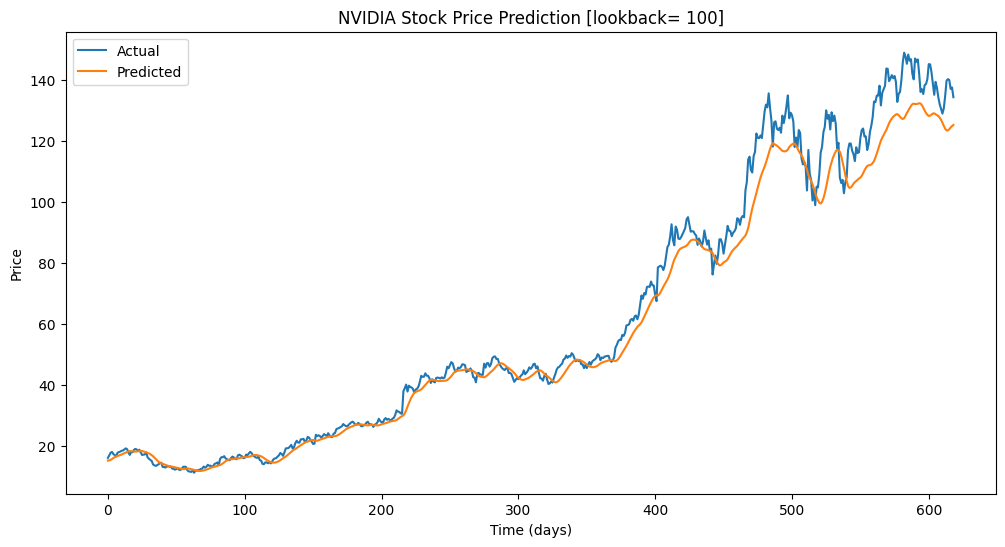

In [ ]:
# Price lookback = 100
X_train, y_train, X_val, y_val, X_test, y_test, scaler = prepare_data("NVDA", "2000-01-01", "2025-01-01", preprocess_data, lookback=100)
model_100 = build_lstm_model(input_shape=(X_train.shape[1], 1))
model_100.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_val, y_val))
plot_history(model_100.history)
predictions, actual = make_predictions(model_100, X_test, y_test, scaler)
plot_predictions(actual, predictions, "Time (days)", "Price", "NVIDIA Stock Price Prediction [lookback= 100]")

[*********************100%***********************]  1 of 1 completed

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━

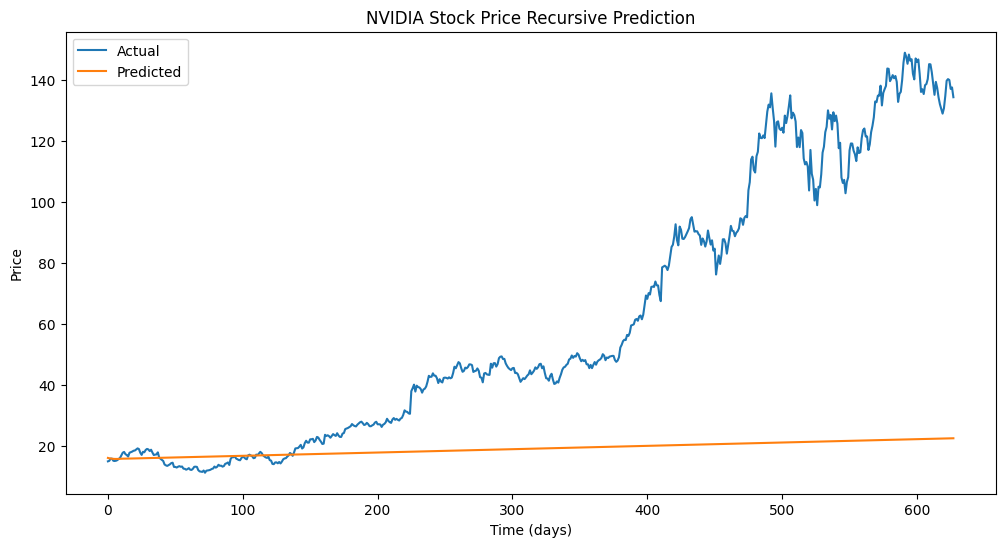

In [ ]:
# Recursive prediction all points
X_train, y_train, X_val, y_val, X_test, y_test, scaler = prepare_data("NVDA", "2000-01-01", "2025-01-01", preprocess_data, lookback=10)
predictions, actual = recursive_prediction(model, X_test, y_test, len(X_test), scaler)
plot_predictions(actual, predictions, "Time (days)", "Price", "NVIDIA Stock Price Recursive Prediction")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


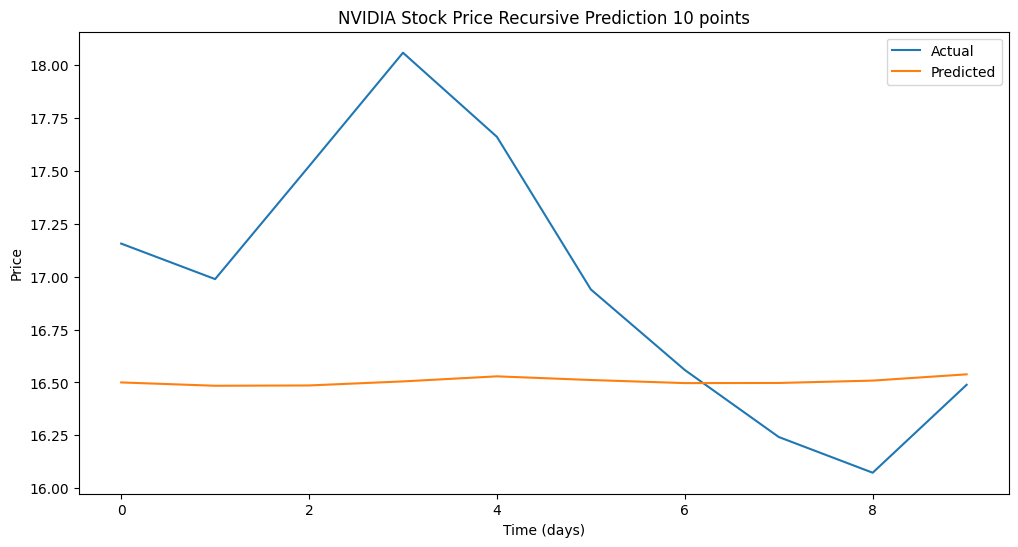

In [ ]:
# Recursive prediction 10 points
start = 110
finish = 120
X_recur = X_test[start:finish]
y_recur = y_test[start:finish]
predictions, actual = recursive_prediction(model, X_recur, y_recur, len(X_recur), scaler)
plot_predictions(actual, predictions, "Time (days)", "Price", "NVIDIA Stock Price Recursive Prediction 10 points")

20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


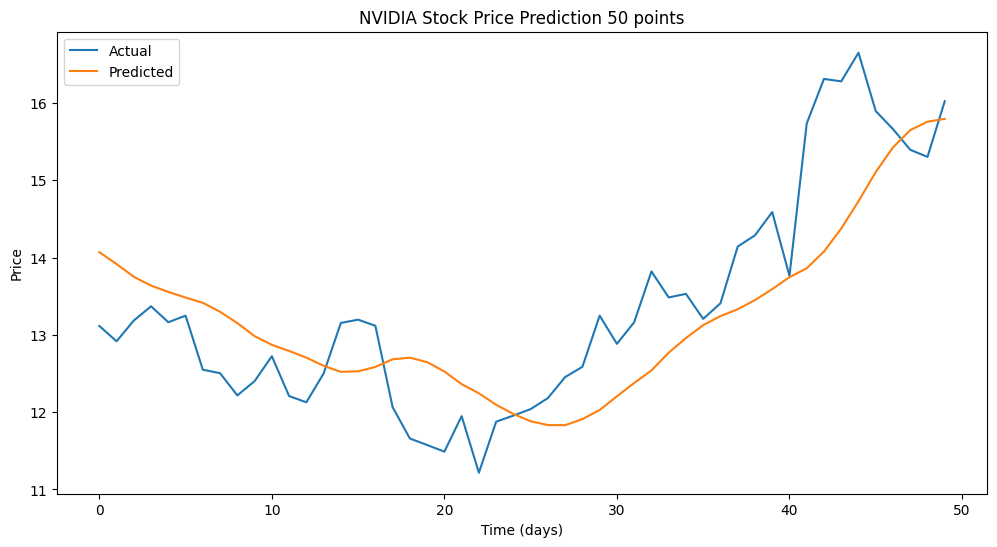

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━

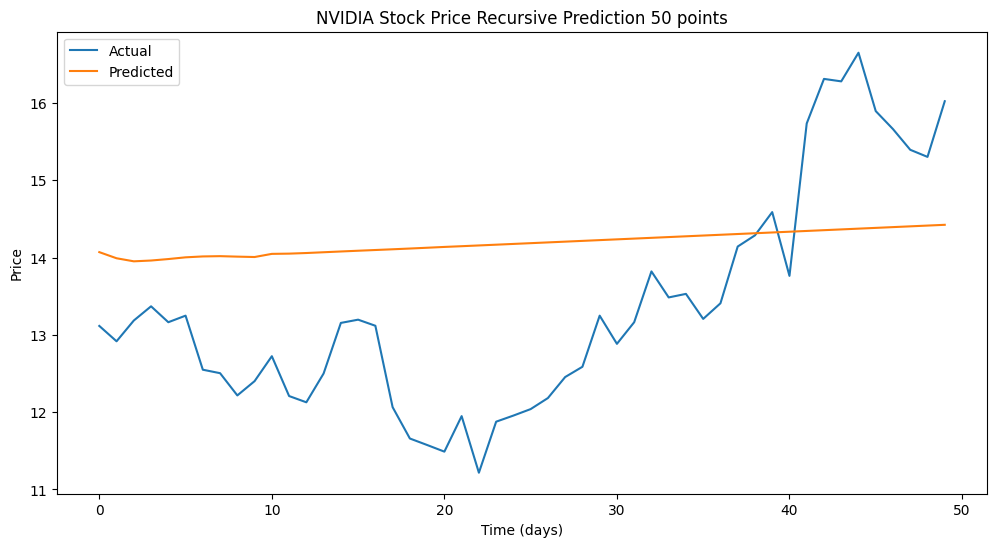

In [ ]:
# Recursive prediction 50 points
predictions, actual = make_predictions(model, X_test, y_test, scaler, start=50, finish=100)
plot_predictions(actual, predictions, "Time (days)", "Price", "NVIDIA Stock Price Prediction 50 points")
predictions, actual = recursive_prediction(model, X_test[50:100], y_test[50:100], 50, scaler)
plot_predictions(actual, predictions, "Time (days)", "Price", "NVIDIA Stock Price Recursive Prediction 50 points")

[*********************100%***********************]  1 of 1 completed


Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


157/157 ━━━━━━━━━━━━━━━━━━━━ 8s 18ms/step - loss: 0.0016 - val_loss: 0.0012
Epoch 2/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - loss: 0.0014 - val_loss: 0.0013
Epoch 3/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - loss: 0.0016 - val_loss: 0.0012
Epoch 4/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step - loss: 0.0015 - val_loss: 0.0012
Epoch 5/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 0.0014 - val_loss: 0.0012
Epoch 6/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 0.0015 - val_loss: 0.0012
Epoch 7/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - loss: 0.0014 - val_loss: 0.0012
Epoch 8/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step - loss: 0.0014 - val_loss: 0.0012
Epoch 9/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 0.0016 - val_loss: 0.0012
Epoch 10/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 0.0015 - val_loss: 0.0012


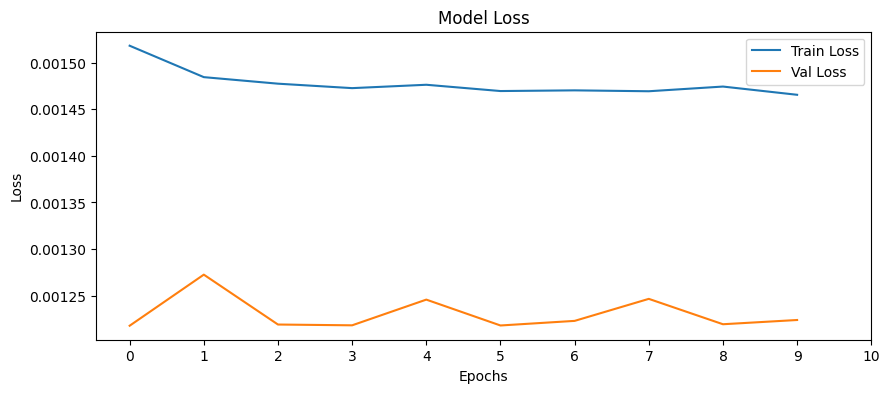

20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step


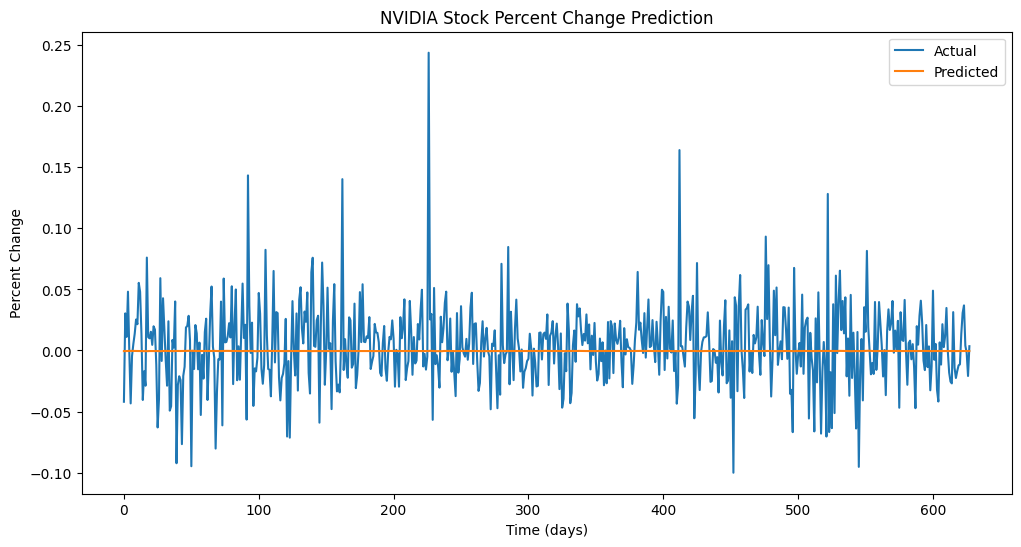

In [54]:
# Price change prediction
X_train, y_train, X_val, y_val, X_test, y_test, scaler = prepare_data("NVDA", "2000-01-01", "2025-01-01", preprocess_data_change)
model = build_lstm_model(input_shape=(X_train.shape[1], 1))
model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_val, y_val))
plot_history(model.history)
predictions, actual = make_predictions(model, X_test, y_test)
plot_predictions(actual, predictions, "Time (days)", "Percent Change", "NVIDIA Stock Percent Change Prediction")

20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


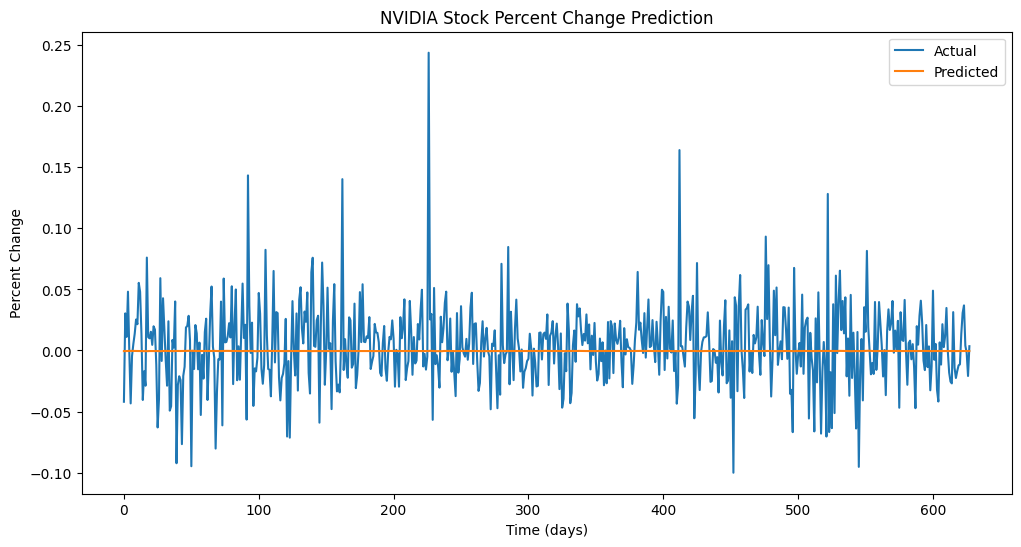

In [55]:
predictions, actual = make_predictions(model, X_test, y_test)
plot_predictions(actual, predictions, "Time (days)", "Percent Change", "NVIDIA Stock Percent Change Prediction")